# 4. Feature engineering, pipelines, tuning, autoML

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Agenda

- Introduction to time series transformers
- Combining transformers for feature engineering with pipelines (composition)
- Parametr tuning and autoML


## 4.1 Why time series transformers?

Tranformers in `sktime` referr to a catch-all term that encompses modular data processing steps.

We use this term in the `sklearn` sense, so this is unrelated to transformers in NLP or deep learning.

### Manual tranformations: doing things the wrong way

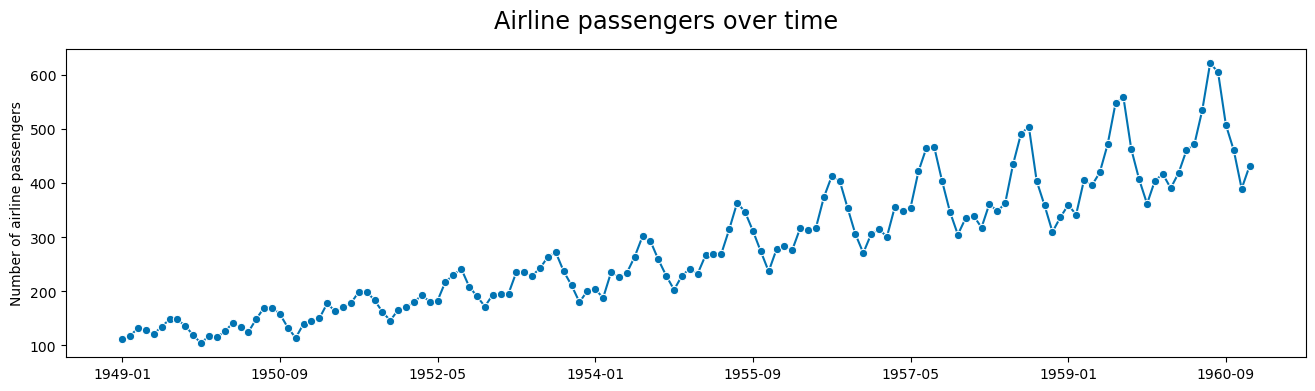

In [2]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()

fig, ax = plot_series(y, title="Airline passengers over time")

observations:

* there is seasonal periodicity, 12 month period
* seasonal periodicity looks multiplicative (not additive) to trend

idea: forecast might be easier

* with seasonality removed
* on logarithmic value scale (multiplication becomes addition)

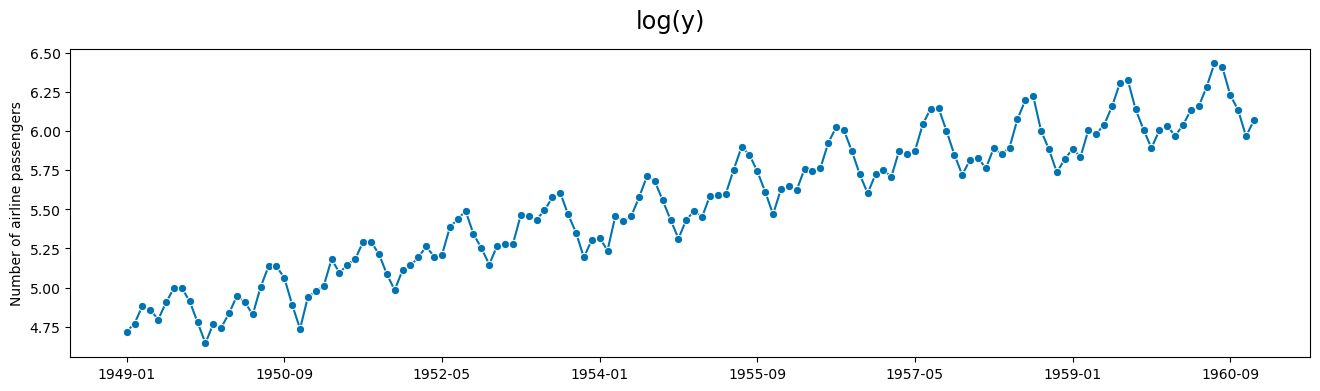

In [3]:
import numpy as np

y_log = np.log(y)

fig, ax = plot_series(y_log, title="log(y)")

this looks additive now!

next: remove seasonality

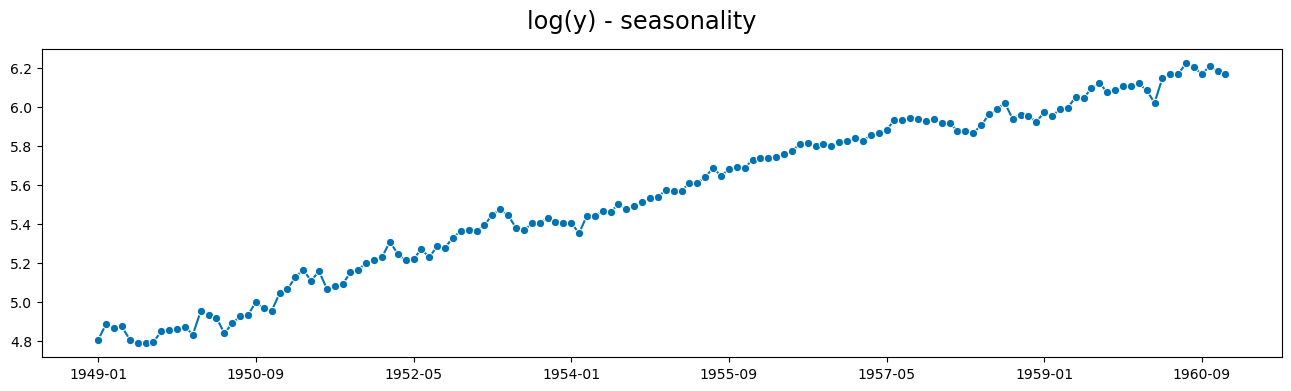

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_result = seasonal_decompose(y_log, period=12)
seasonal = seasonal_result.seasonal
y_log_deseasonalised = y_log - seasonal

fig, ax = plot_series(y_log_deseasonalised, title="log(y) - seasonality")

now:

* forecast on this
* add back seasonal component
* invert logarithm (exponentiate)

start with forecast...

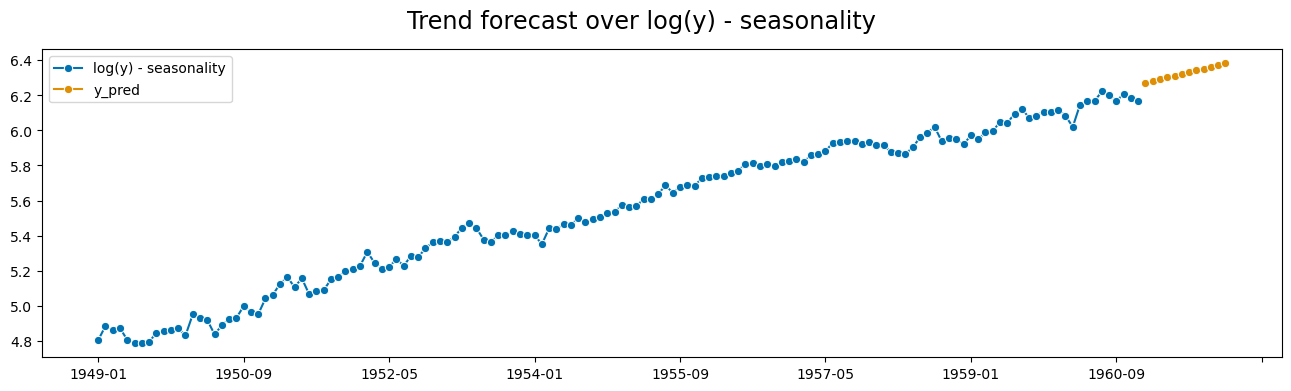

In [5]:
from sktime.forecasting.trend import TrendForecaster

forecaster = TrendForecaster()

fh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] # Alternatively: list(range(1, 13))
y_pred = forecaster.fit_predict(y_log_deseasonalised, fh=fh)

fig, ax = plot_series(
    y_log_deseasonalised,
    y_pred,
    labels=["log(y) - seasonality", "y_pred"],
    title="Trend forecast over log(y) - seasonality",
)

Looks reasonable! Now back to original domain:

* add back seasonal component
* invert logarithm (exponentiate)

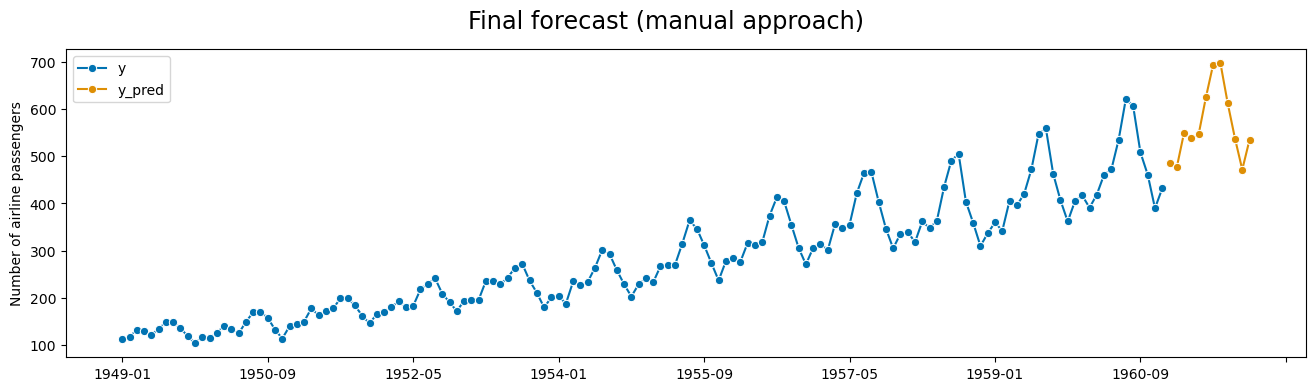

In [6]:
y_pred_add_seasonality = y_pred + seasonal[0:12].values
y_pred_orig = np.exp(y_pred_add_seasonality)

fig, ax = plot_series(y, y_pred_orig, labels=["y", "y_pred"], title="Final forecast (manual approach)")

Ok, done! But it was tedious!

Is there a better way?

### `sktime` transformers: doing things the right way

Solution: use transformers & pipelines!

Same interface at every step! Easily composable!

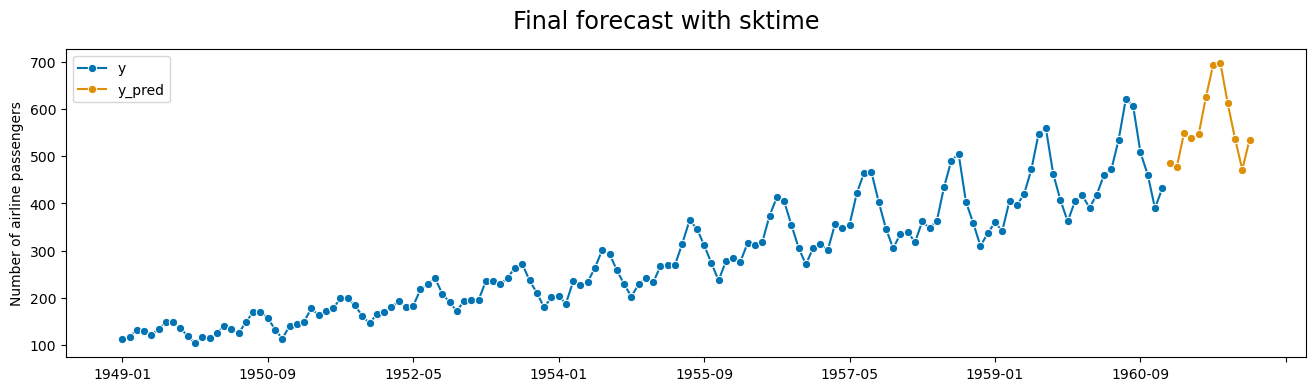

In [7]:
from sktime.forecasting.trend import TrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

forecaster = LogTransformer() * Deseasonalizer(sp=12) * TrendForecaster()

fh = list(range(1, 13))
y_pred = forecaster.fit_predict(y, fh=fh)

fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"], title="Final forecast with sktime")

what happened here?

The "chain" operator `*` creates a "forecasting pipeline"

Has the same interface as all other forecasters! No additional data fiddling!

Transformers "slot in" as standardized components.

In [8]:
forecaster

TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   TrendForecaster()])

Let's look at this in more detail:

* `sktime` transformers interface
* `sktime` pipeline building

## 4.2 Transformer types in `sktime`

Common types of transformation in `sktime`:

| from | to | base class | examples (sci) | examples (`sktime`) |
| --- | --- | --- | --- | --- |
| time series | scalar features | `BaseTransformer` (`Primitives` output) | `tsfresh`, or 7-number-summary | `Catch22`,`SummaryTransformer` |
| time series | time series | `BaseTransformer` (`Series`, `instancewise`)  | detrending, smoothing, filtering, lagging | `Detrender`,`Differencer`, `Lag`, `Filter` |
| time series panel | also a panel | `BaseTransformer` (`Series` output)  | principal component projection | `PCATransformer`,`PaddingTransformer` |
| two feature vectors | a scalar | `BasePairwiseTransformer` | Euclidean distance, L1 distance | `ScipyDist`, `AggrDist`, `FlatDist` |
| two time series | a scalar | `BasePairwiseTransformerPanel` | DTW distance, alignment kernel | `DtwDist`, `EditDist` |

To illustrate the difference, we compare two transformers with different output:

- The Box-Cox transformer `BoxCoxTransformer`, which transforms a time series to a time series
- The summary transformer `SummaryTransformer`, which transforms a time series to descriptive scalars (e.g. mean, standard deviation, etc.)

In [ ]:
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.summarize import SummaryTransformer

y = load_airline()

boxcox = BoxCoxTransformer()
summary = SummaryTransformer()

In [ ]:
# BoxCoxTransformer() produces a pd.Series
boxcox.fit_transform(y)

In [ ]:
# SummaryTransformer() produces a (set of) scalar (values)
summary.fit_transform(y)

In [ ]:
from sktime.registry import all_estimators

# now subset to transformers that extract scalar features
all_estimators(
    "transformer",
    as_dataframe=True,
    filter_tags={"scitype:transform-output": "Series"},
    suppress_import_stdout=False,
)

### Transformer broadcasting

Like forecasters, transformers are automatically broadcast to rows and/or columns depending on the setting:

* Column broadcasting: if data is multivariate and transform assumes univariate data.
* Row broadcasting: if data is panel or hierarchical and transform assumes single time series.

In [ ]:
from odsc_utils import load_product_hierarchy

y_hier = load_product_hierarchy()

y_hier

In [ ]:
from sktime.transformations.series.boxcox import BoxCoxTransformer

boxcox = BoxCoxTransformer(method="mle")
boxcox.fit_transform(y_hier)

In [ ]:
boxcox.transformers_

## 4.3 Combining transformers, feature engineering

transformers are natural pipeline components

* data processing steps
* feature engineering steps
* post processing steps

they can be combined in a number of other ways:

* pipelining = sequential chaining
* feature union = parallel, addition of features
* feature subsetting = selecting columns
* inversion = switch transform and inverse
* multiplexing = switching between transformers
* passthrough = switch on/ off

### Chaining transformers via `*`

In [ ]:
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.summarize import SummaryTransformer

pipe = Differencer() * SummaryTransformer()

# this constructs a TransformerPipeline, which is also a transformer
pipe

In [ ]:
from sktime.utils._testing.hierarchical import _bottom_hier_datagen

X = _bottom_hier_datagen(no_levels=1, no_bottom_nodes=2)

# this is a transformer with the same interface
# first applies differencer, then summary transform
pipe.fit_transform(X)

compatible with sklearn transformers!

default applies sklearn transformer per individual time series as a data frame table

In [ ]:
from sklearn.preprocessing import StandardScaler

pipe = Differencer() * StandardScaler()

pipe

In [ ]:
pipe.fit_transform(X)

pipeline-adaptor chains can be constructed manually:

* `sktime.transformations.compose.TransformerPipeline`
* `sktime.transformations.series.adapt.TabularToSeriesAdaptor` for `sklearn`

composites are compatible with `get_params` / `set_params` parameter interface:

In [ ]:
pipe.get_params()

### Feature union via `+`

In [ ]:
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Differencer() + Lag()

# this constructs a FeatureUnion, which is also a transformer
pipe

In [ ]:
from sktime.utils._testing.hierarchical import _bottom_hier_datagen

X = _bottom_hier_datagen(no_levels=1, no_bottom_nodes=2)

# applies both Differencer and Lag, returns transformed in different columns
pipe.fit_transform(X)

to retain the original columns, use the `Id` transformer:

In [ ]:
from sktime.transformations.compose import Id
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Id() + Differencer() + Lag([1, 2], index_out="original")

pipe.fit_transform(X)

In [ ]:
# parameter inspection
pipe.get_params()

### Subset input columns via `[colname]`

let's say we want to apply `Differencer` to column 0, and `Lag` to column 1

also we keep the original columns for illustration

In [ ]:
from sktime.utils._testing.hierarchical import _make_hierarchical

X = _make_hierarchical(
    hierarchy_levels=(2, 2), n_columns=2, min_timepoints=3, max_timepoints=3
)

X

In [ ]:
from sktime.transformations.compose import Id
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Id() + Differencer()["c0"] + Lag([1, 2], index_out="original")["c1"]

pipe.fit_transform(X)

auto-generated names can be replaced by using `FeatureUnion` explicitly:

In [ ]:
from sktime.transformations.compose import FeatureUnion

pipe = FeatureUnion(
    [
        ("original", Id()),
        ("diff", Differencer()["c0"]),
        ("lag", Lag([1, 2], index_out="original")),
    ]
)

pipe.fit_transform(X)

### autoML structure compositors: multiplexer switch `¦` and on/off switch `-`

expose decisions as parameter

* do we want differencer *or* lag? for tuning later
* do we want [differencer and lag] or [original features and lag] ? for tuning later

In [ ]:
# differencer or lag

from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Differencer() | Lag()

pipe.get_params()

the `selected_transformer` parameter exposes the choice:

does this behave as `Lag` or `Differencer`?

In [ ]:
# switch = Lag -> this is a Lag transformer now!
pipe.set_params(selected_transformer="Lag")

In [ ]:
# switch = Lag -> this is a Differencer now!
pipe.set_params(selected_transformer="Differencer")

similar, on/off switch with `-`

same as multiplexer between wrapped transformer and `Id`

In [ ]:
optional_differencer = -Differencer()

# this behaves as Differencer now
optional_differencer

In [ ]:
# this is now just the identity transformer
optional_differencer.set_params(passthrough=True)

see more later in part 3 on how to use this with tuning for full structural AutoML!

## 4.4 Parameter tuning and autoML

### 4.4.1 Parameter estimation, e.g., seasonality, stationarity

In the airline data example, it was pretty evident that we had seasonality. 

But sometimes it isn't so clear cut... 

How do to estimate seasonality? How to automate seasonality estimation?

In [ ]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()

fig, ax = plot_series(y)

The classical way uses autocorrelation plots.

Manual approach using `statsmodels` or `sktime` (thinly wrapping `statsmodels`):

In [ ]:
from sktime.utils.plotting import plot_correlations

# acf/pacf on differences to ensure stationarity, there is a visible trend
fig, ax = plot_correlations(y.diff()[1:], lags=16)

`sktime` has a systematic interface for parameter estimators that allows auto-setting of seasonality:

the "parameter estimator" type:

In [ ]:
from sktime.param_est.seasonality import SeasonalityACF
from sktime.transformations.series.difference import Differencer

# compute seasonality on first differences
sp_est = Differencer() * SeasonalityACF()

sp_est.fit(y)

In [ ]:
sp_est.get_fitted_params()["sp"]

In [ ]:
# more stats in here
list(sp_est.get_fitted_params().keys())

using pipelining, we can plug in the fitted `sp` parameter into any estimator!

In [ ]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.param_est.plugin import PluginParamsForecaster

fcst = NaiveForecaster()
sp_auto = PluginParamsForecaster(sp_est, fcst)
sp_auto.fit(y, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [ ]:
sp_auto.forecaster_.get_params()["sp"]

In [ ]:
y_pred = sp_auto.predict()

title = f"NaiveForecaster with ACF auto-fitted seasonality"
fig, ax = plot_series(
    y, y_pred, labels=["y", "y_pred"], title=title
)

also useful: conditional transformer

e.g., "test for seasonality, and deseasonalize, but only if there is seasonality"

In [ ]:
from sktime.param_est.seasonality import SeasonalityACF
from sktime.transformations.compose import TransformIf
from sktime.transformations.series.detrend import Deseasonalizer

seasonal = SeasonalityACF(candidate_sp=12)
deseason = Deseasonalizer(sp=12)
cond_deseason = TransformIf(seasonal, "sp", "!=", 1, deseason)
# if seasonality is significant at sp=12, then deseasonalize at sp=12

y_hat = cond_deseason.fit_transform(y)

this can be pipelined with a forecaster:

In [ ]:
forecaster_with_cond_deaseason = cond_deseason * NaiveForecaster()

also useful: stationarity tester `StationarityADF` (Dickey-Fuller) - combine with `Differencer`!

### 4.4.2 Tuning using grid or random search

Grid/parameter tuning has same syntax as in `sklearn`:

* `get_params` strings and `dict` to set parameter grid/range
* `cv` splitter to define evaluation modus

In [ ]:
from sktime.datasets import load_shampoo_sales
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

y = load_shampoo_sales()
y_train, y_test = temporal_train_test_split(y=y, test_size=6)

plot_series(y_train, y_test, labels=["y_train", "y_test"]);

In [ ]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.utils.plotting import plot_windows

cv = ExpandingWindowSplitter(fh=[1,2,3,4,5,6], initial_window=12, step_length=1)
plot_windows(cv=cv, y=y_train)

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanSquaredError

forecaster = ExponentialSmoothing()
param_grid = {
    "sp": [4, 6, 12],
    "seasonal": ["add", "mul"],
    "trend": ["add", "mul"],
    "damped_trend": [True, False],
}
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),
)

In [ ]:
gscv.fit(y_train)
fh = [1, 2, 3, 4, 5, 6]
y_pred = gscv.predict(fh=fh)

In [ ]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

In [ ]:
gscv.best_params_

In [ ]:
# all fitted parameters also accessible via get_fitted_params
# this can be used in parameter plugin etc
gscv.get_fitted_params()["best_params"]

In [ ]:
gscv.best_forecaster_

for pipelines and composites, parameter names are `[componentname]__[paramname]`:

In [ ]:
from sklearn.preprocessing import PowerTransformer, RobustScaler, MinMaxScaler
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

forecaster = TransformedTargetForecaster(
    steps=[
        ("detrender", Detrender()),
        ("deseasonalizer", Deseasonalizer()),
        ("minmax", TabularToSeriesAdaptor(MinMaxScaler((1, 10)))),
        ("power", TabularToSeriesAdaptor(PowerTransformer())),
        ("scaler", TabularToSeriesAdaptor(RobustScaler())),
        ("forecaster", ExponentialSmoothing()),
    ]
)

# using dunder notation to access inner objects/params as in sklearn
param_grid = {
    # deseasonalizer
    "deseasonalizer__model": ["multiplicative", "additive"],
    # power
    "power__transformer__method": ["yeo-johnson", "box-cox"],
    "power__transformer__standardize": [True, False],
    # forecaster
    "forecaster__sp": [4, 6, 12],
    "forecaster__seasonal": ["add", "mul"],
    "forecaster__trend": ["add", "mul"],
    "forecaster__damped_trend": [True, False],
}

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),  # set custom scoring function
)
gscv.fit(y_train)
y_pred = gscv.predict(fh=fh)

when using dunders - and in general - paramater names can be inspected using `get_params`

In [ ]:
forecaster = \
    Detrender() \
    * Deseasonalizer() \
    * MinMaxScaler((1, 10)) \
    * PowerTransformer() \
    * RobustScaler() \
    * ExponentialSmoothing()

In [ ]:
forecaster.get_params()

### 4.4.3 AutoML

Let's begin by loading the data for which to do AutoML on and split into train and test.

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.datasets import load_airline

y = load_airline()

y_train, y_test = temporal_train_test_split(y=y, test_size=12)
fig, ax = plot_series(y_train, y_test, labels=["train", "test"])

Now we define the sklearn tree-based regressor and create a forecaster from it using `make_reduction`.

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sktime.forecasting.compose import make_reduction

regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=12)

In this step we create a pipeline with the all the different steps we wish to try out.

In [ ]:
from sklearn.preprocessing import RobustScaler

from sktime.transformations.compose import OptionalPassthrough
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.detrend import Detrender, Deseasonalizer

forecasting_pipeline = TransformedTargetForecaster(
    steps=[
        ("detrender", OptionalPassthrough(Detrender())),
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("differencer", OptionalPassthrough(Differencer())),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(RobustScaler()))),
        ("forecaster", forecaster),
    ]
)

We would now need to define the parameter grid for the grid search. 

To see what are the available options we can inspect the parameters of the pipeline object.

In [ ]:
forecasting_pipeline.get_params()

In [ ]:
param_grid = {
    "detrender__passthrough": [True, False],
    "deseasonalizer__passthrough": [True, False],
    "differencer__passthrough": [True, False],
    "scaler__passthrough": [True, False],
    "forecaster__window_length": [6, 12, 18],
    "forecaster__estimator__learning_rate": [0.1, 0.2], # Note we can also access the regressor parameters
}

Now let's set up the cross validation strategy

In [ ]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.utils.plotting import plot_windows

fh = list(range(1, 13))
cv = ExpandingWindowSplitter(initial_window=12*6, fh=fh, step_length=len(fh))
n_folds = cv.get_n_splits(y_train)
plot_windows(cv, y_train)

In [ ]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

gscv = ForecastingGridSearchCV(
    forecaster=forecasting_pipeline,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=smape,
    error_score="raise",
)

gscv.fit(y=y_train, fh=fh)

We can now inspect the grid search object to see which was the best model and why.

In [ ]:
gscv.best_forecaster_

In [ ]:
gscv.cv_results_.sort_values(by=f"rank_test_MeanAbsolutePercentageError")

Finally we can use the best performing forecaster in the backtests to make predictions.

In [ ]:
y_pred = gscv.predict(fh=fh)
title = f"Best model found through grid search - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title)

### Credits: notebook 4 - feature engineering, pipelines, tuning, autoML

notebook creation: marrov, fkiraly